### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpingFunctions import Autoencoder, GMM

### Data Loading and Preprocessing

In [2]:
df = pd.read_csv('data.csv').drop(columns=['id', 'Unnamed: 32'], errors='ignore')
X_raw = df.drop(columns=['diagnosis']).values
X = (X_raw - np.mean(X_raw, axis=0)) / np.std(X_raw, axis=0)
input_dim = X.shape[1]

### Autoencoder Implementation & Training

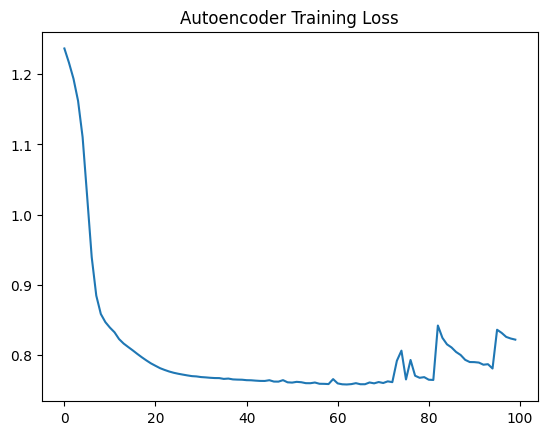

In [3]:
# Architecture: Input(30) -> 20 -> 15 -> 10 -> Bottleneck(2) -> 10 -> 15 -> 20 -> Input(30)
layers = [input_dim, 20, 15, 10, 2, 10, 15, 20, input_dim]
activations = ['relu', 'relu', 'relu', 'tanh', 'relu', 'relu', 'relu', 'sigmoid']

ae_model = Autoencoder(layers, activations, lr=0.01, l2_reg=0.001)
history = ae_model.train(X, epochs=100)

# Pre-calculate the reduced data for Experiment 6
X_reduced = ae_model.get_bottleneck(X)

plt.plot(history)
plt.title("Autoencoder Training Loss")
plt.show()

### Training the Autoencoder

Training Autoencoder...


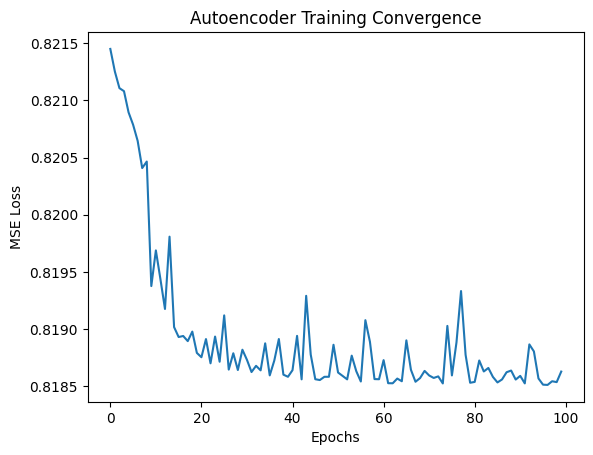

In [4]:
# Train AE for 100 epochs
print("Training Autoencoder...")
ae_loss_history = ae_model.train(X, epochs=100, batch_size=32)

# Extract the latent representation (Bottleneck) for later use
X_bottleneck = ae_model.get_bottleneck(X)

plt.plot(ae_loss_history)
plt.title("Autoencoder Training Convergence")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.show()

### Experiment 2

In [7]:
print("Experiment 2: GMM on Original Data")
gmm_orig = GMM(n_components=2, cov_type='full')
gmm_orig.fit(X)

print(f"Original Data - BIC: {gmm_orig.bic:.2f}, AIC: {gmm_orig.aic:.2f}")

Experiment 2: GMM on Original Data
Original Data - BIC: 3127.22, AIC: -1177.56


### Experiment 6

Experiment 6: GMM after Autoencoder
AE Reduced Data - BIC: -7635.84, AIC: -7683.62


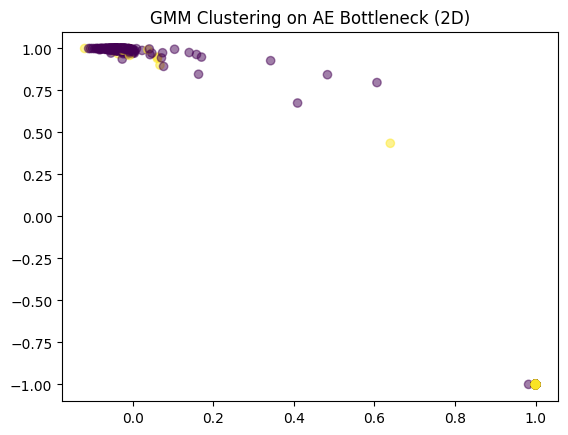

In [8]:
print("Experiment 6: GMM after Autoencoder")
gmm_ae = GMM(n_components=2, cov_type='full')
gmm_ae.fit(X_reduced)

print(f"AE Reduced Data - BIC: {gmm_ae.bic:.2f}, AIC: {gmm_ae.aic:.2f}")

# Optional: Visualize the AE separation
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['diagnosis'].map({'M':1, 'B':0}), alpha=0.5)
plt.title("GMM Clustering on AE Bottleneck (2D)")
plt.show()